# Deriving Data-Driven Weights for `attractiveness_score`

> **Let the data set the weights by projecting key “attractiveness” drivers onto the first principal component.**

Steps covered:

1. **Load** the feature table (`features_v6.parquet`).
2. **Derive** `active_prob = 1 − placebo_flag / num_arms` (fill missing with 1.0).
3. **Select & scale** candidate drivers:
   - `active_prob`, `assessments_n`, `elig_crit_n`, `novelty_score`, `# patients`, `num_arms`.
   - Impute (median) → rank/quantile transform to a **uniform** distribution.
4. **Fit** a 1-component **PCA** to obtain data-driven loadings (weights).
5. **Inspect** the component loadings and compare with any hand-tuned formula.
6. **Build** `attractiveness_score_100` by min-max scaling the PCA score to **0–100**.
7. **Export** artifacts (pipeline, min/max, design columns, loadings) for use in the main pipeline.


In [1]:
# Import weights
from pathlib import Path
import numpy as np, pandas as pd, pickle, json, matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [2]:
# paths
FEATURES_PATH = Path(
    "/Users/jonathanfung/Library/Mobile Documents/com~apple~CloudDocs/"
    "UCL MSc DSML/MSc Project/data/processed/features_v5.parquet"
)
MODEL_OUT  = FEATURES_PATH.parent / "attractiveness_score_artifacts" / "attractiveness_score_model.pkl"

df = pd.read_parquet(FEATURES_PATH)

In [3]:
# Derive activate probability
df["active_prob"] = 1 - df["placebo_flag"] / df["num_arms"].replace(0, np.nan)
df["active_prob"] = df["active_prob"].fillna(1)

In [4]:
# Feature list
design_cols = [
    "active_prob",
    "assessments_n",
    "elig_crit_n",
    "novelty_score",
    "# patients",
    "num_arms",
]


In [5]:
# pipeline
pipe = Pipeline(
    [
        ("imp",  SimpleImputer(strategy="median")),
        ("rank", QuantileTransformer(output_distribution="uniform")),
        ("pca",  PCA(n_components=1, random_state=0)),
    ]
)

z = pipe.fit_transform(df[design_cols]).ravel()    # (n_samples,)


In [6]:
artefact = dict(
    pipeline = pipe,
    Smin     = float(z.min()),
    Smax     = float(z.max()),
    design   = design_cols,   
)

with open(MODEL_OUT, "wb") as f:
    pickle.dump(artefact, f)

print("Saved model →", MODEL_OUT)

# dump weights to JSON for inspection
weights = pd.Series(
    pipe.named_steps["pca"].components_[0],
    index=design_cols
)

JSON_OUT = MODEL_OUT.with_suffix(".json")
weights.round(6).to_json(JSON_OUT, indent=2)   
print("  ↳ loadings written to", JSON_OUT)


Saved model → /Users/jonathanfung/Library/Mobile Documents/com~apple~CloudDocs/UCL MSc DSML/MSc Project/data/processed/attractiveness_score_artifacts/attractiveness_score_model.pkl
  ↳ loadings written to /Users/jonathanfung/Library/Mobile Documents/com~apple~CloudDocs/UCL MSc DSML/MSc Project/data/processed/attractiveness_score_artifacts/attractiveness_score_model.json


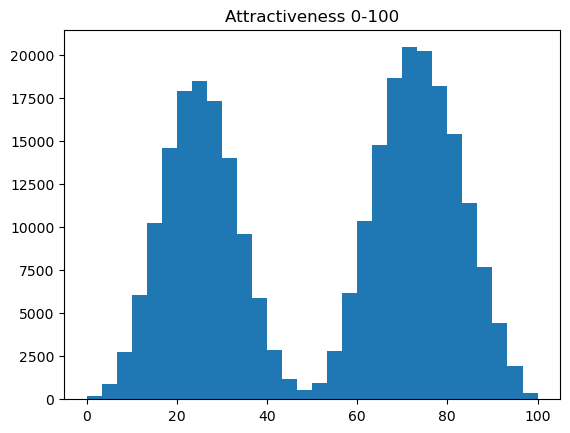

In [7]:
#Visual check disstribution
score = 100 * (z - artefact["Smin"]) / (artefact["Smax"] - artefact["Smin"])
plt.hist(score, bins=30); plt.title("Attractiveness 0-100"); plt.show()